In [1]:
import socket
import json
import time
import threading
import numpy as np
from Quaternion import *
from VectorKalmanFilter import *
import matplotlib.pyplot as plt

In [2]:
class SensorData:
    def __init__(self, ip = '192.168.1.105', port = 6666):
        self.ip = ip
        self.port = port
        self.sock = socket.socket(socket.AF_INET,socket.SOCK_STREAM)#创建一个服务器socket监听
        self.sock.connect((self.ip, self.port))
        self.data = {}
        self.time = time.time()
        self.threading = threading.Thread(target=self.setData, args = (self,))
        self.threading.start()
        
    def getData(self):
        data = ''
        
        while True:
            b_data = self.sock.recv(256)
            data += b_data.decode('utf-8')
            try:
                jdata = json.loads(data.split('\n')[-2])
                data = ''
                break
            except:
                continue
        self.time = time.time()
        return jdata
    
    def setData(self, object):
        while True:
            self.data = self.getData()
            object.data = self.data
            
    def close(self):
        self.sock.close()
        
    def restart(self):
        self.__init__(self.ip, self.port)


In [3]:
class motion:
    def __init__(self):
        #初始状态
        self.sx, self.sy, self.sz = 0, 0, 0 
        self.vx, self.vy, self.vz = 0, 0, 0
        self.ax, self.ay, self.az = 0, 0, 0
        
        self.sx_list = [0]
        self.sy_list = [0]
        self.sz_list = [0]
        
        
        self.dt = 0
        
        self.Sx = np.array([[self.sx], [self.vx], [self.ax]])
        self.Sy = np.array([[self.sy], [self.vy], [self.ay]])
        self.Sz = np.array([[self.sz], [self.vz], [self.az]])
        
        self.M = np.ones((3,3))*0.01

        #建立 3个滤波器，为了求逆简单!!
        self.A = self.setA(self.dt)
        self.B = np.array([[0],[0],[1]])
        self.H = np.array([[0,0,1]])
        self.Q = np.array([[0.2]])
        self.C = np.array([[0.3]])
        # 卡尔曼滤波
        self.kalmanFilerX = VectorKalmanFilter(self.Sx, self.M, self.A, self.B, self.H, self.Q, self.C)
        self.kalmanFilerY = VectorKalmanFilter(self.Sy, self.M, self.A, self.B, self.H, self.Q, self.C)
        self.kalmanFilerZ = VectorKalmanFilter(self.Sz, self.M, self.A, self.B, self.H, self.Q, self.C)
        
    def go(self,ax,ay,az,dt):
        self.A = self.setA(dt)
        self.kalmanFilerX.A = self.A
        self.kalmanFilerY.A = self.A
        self.kalmanFilerZ.A = self.A
        
        self.Sx = self.kalmanFilerX.forward(np.array([[ax]]))
        self.Sy = self.kalmanFilerY.forward(np.array([[ay]]))
        self.Sz = self.kalmanFilerZ.forward(np.array([[az]]))
        
        self.sx = self.Sx[0,0]
        self.sy = self.Sy[0,0]
        self.sz = self.Sz[0,0]
        self.sx_list.append(self.sx)
        self.sy_list.append(self.sy)
        self.sz_list.append(self.sz)
        
        
        
    def setA(self,dt):
        self.A = np.array([[1, dt, dt**2],
                           [0,  1,    dt],
                           [0,  0,     1]])
        return self.A

In [4]:
def getRotationVector(x,y,z):
    v = np.linalg.norm([x,y,z])**2
    s = (1-v)**0.5
    return Quaternion(x,y,z,s)

In [5]:
myData = SensorData()

In [6]:
while myData.data == {}:
    pass

In [7]:
r0 = getRotationVector(*myData.data['rotationVector']['value']).inverse()
g = Quaternion(0,0,9.8)
o = Quaternion()
p1 = Quaternion(-5,-15,0)
p2 = Quaternion(-5,15,0)
p3 = Quaternion(5,15,0)
p4 = Quaternion(5,-15,0)

p5 = Quaternion(-5,-15,2)
p6 = Quaternion(-5,15,2)
p7 = Quaternion(5,15,2)
p8 = Quaternion(5,-15,2)
sock = socket.socket(socket.AF_INET,socket.SOCK_STREAM)#创建一个服务器socket监听
sock.connect(('192.168.1.116',5555))

In [8]:
i = 0
x = []
m = motion()

In [9]:
myData.data

{'accelerometer': {'timestamp': 26556576813443,
  'value': [0.2590027, -0.7761688, 9.695465]},
 'gravity': {'timestamp': 26556569306119,
  'value': [0.27616847, -0.7854437, 9.771244]},
 'gyroscope': {'timestamp': 26556569306119,
  'value': [0.00076293945, 0.00036621094, 0.0011291504]},
 'linearAcceleration': {'timestamp': 26556569306119,
  'value': [-0.014857352, 0.0027095675, 0.0058965683]},
 'rotationVector': {'timestamp': 26556569306119,
  'value': [-0.042086557, 0.0058280802, -0.45755628]}}

In [10]:
t = time.time()
sock.recv(1024)
while True:
    gx,gy,gz = myData.data['gravity']['value']  # 重力加速度
    ax,ay,az = myData.data['linearAcceleration']['value'] # 线性加速度
    
    r = getRotationVector(*myData.data['rotationVector']['value']) # 旋转矩阵
    dt = (time.time() - t) # 时间差
    m.go(ax,ay,az,dt) #运动
    t = time.time()
    p1_ = p1.Rotate(r).Rotate(r0)
    p2_ = p2.Rotate(r).Rotate(r0)
    p3_ = p3.Rotate(r).Rotate(r0)
    p4_ = p4.Rotate(r).Rotate(r0)

    p5_ = p5.Rotate(r).Rotate(r0)
    p6_ = p6.Rotate(r).Rotate(r0)
    p7_ = p7.Rotate(r).Rotate(r0)
    p8_ = p8.Rotate(r).Rotate(r0)
    
    data1 = [gx,gy,gz]
    data2 = [p1_.x, p2_.x, p3_.x, p4_.x, p1_.x, p5_.x, p6_.x, p2_.x, p6_.x, p7_.x, p3_.x, p7_.x, p8_.x, p4_.x, p8_.x,p5_.x]
    data3 = [p1_.y, p2_.y, p3_.y, p4_.y, p1_.y, p5_.y, p6_.y, p2_.y, p6_.y, p7_.y, p3_.y, p7_.y, p8_.y, p4_.y, p8_.y,p5_.y]
    data4 = [p1_.z, p2_.z, p3_.z, p4_.z, p1_.z, p5_.z, p6_.z, p2_.z, p6_.z, p7_.z, p3_.z, p7_.z, p8_.z, p4_.z, p8_.z,p5_.z]
    data5 = [m.sx,m.sy,m.sz]
    dataSend = '{'+ str(data1) + ';' + str(data2) + ';' + str(data3) + ';' + str(data4) + ';' + str(data5) + '}' 
    sock.send(bytes(dataSend,'utf-8'))
    sock.recv(1024)

KeyboardInterrupt: 

In [ ]:
0.8520445732242607**2 + 0.03458354**2 + 0.020975312**2 + 0.27101845**2

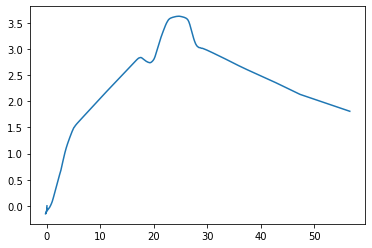

In [11]:
plt.plot(m.sx_list,m.sy_list)

In [ ]:
dt